# Comparing the Performance of Different Classifier Models for Direct Marketing Campaigns

This notebook illustrates how to compare the performance of various classifier models, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines, against a sample direct marketing campaign use case.

We will utilize a dataset from the UCI Machine Learning repository [[link]](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  This dataset originated from a Portugese banking institution and is a collection of 17 marketing campaigns that occurred between May 2008 and November 2010.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset Features

#### Input (Predictor) Variables:
```
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)
```

#### Output (Target) Variable:
```
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Exploratory Data Analysis

In [4]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df, title="Profiling Report")
#profile.to_file("data_profile_report.html")

In [5]:
#profile.to_widgets()

In [6]:
# Drop duplicates in place
df.drop_duplicates(inplace=True)

df.shape


(41176, 21)

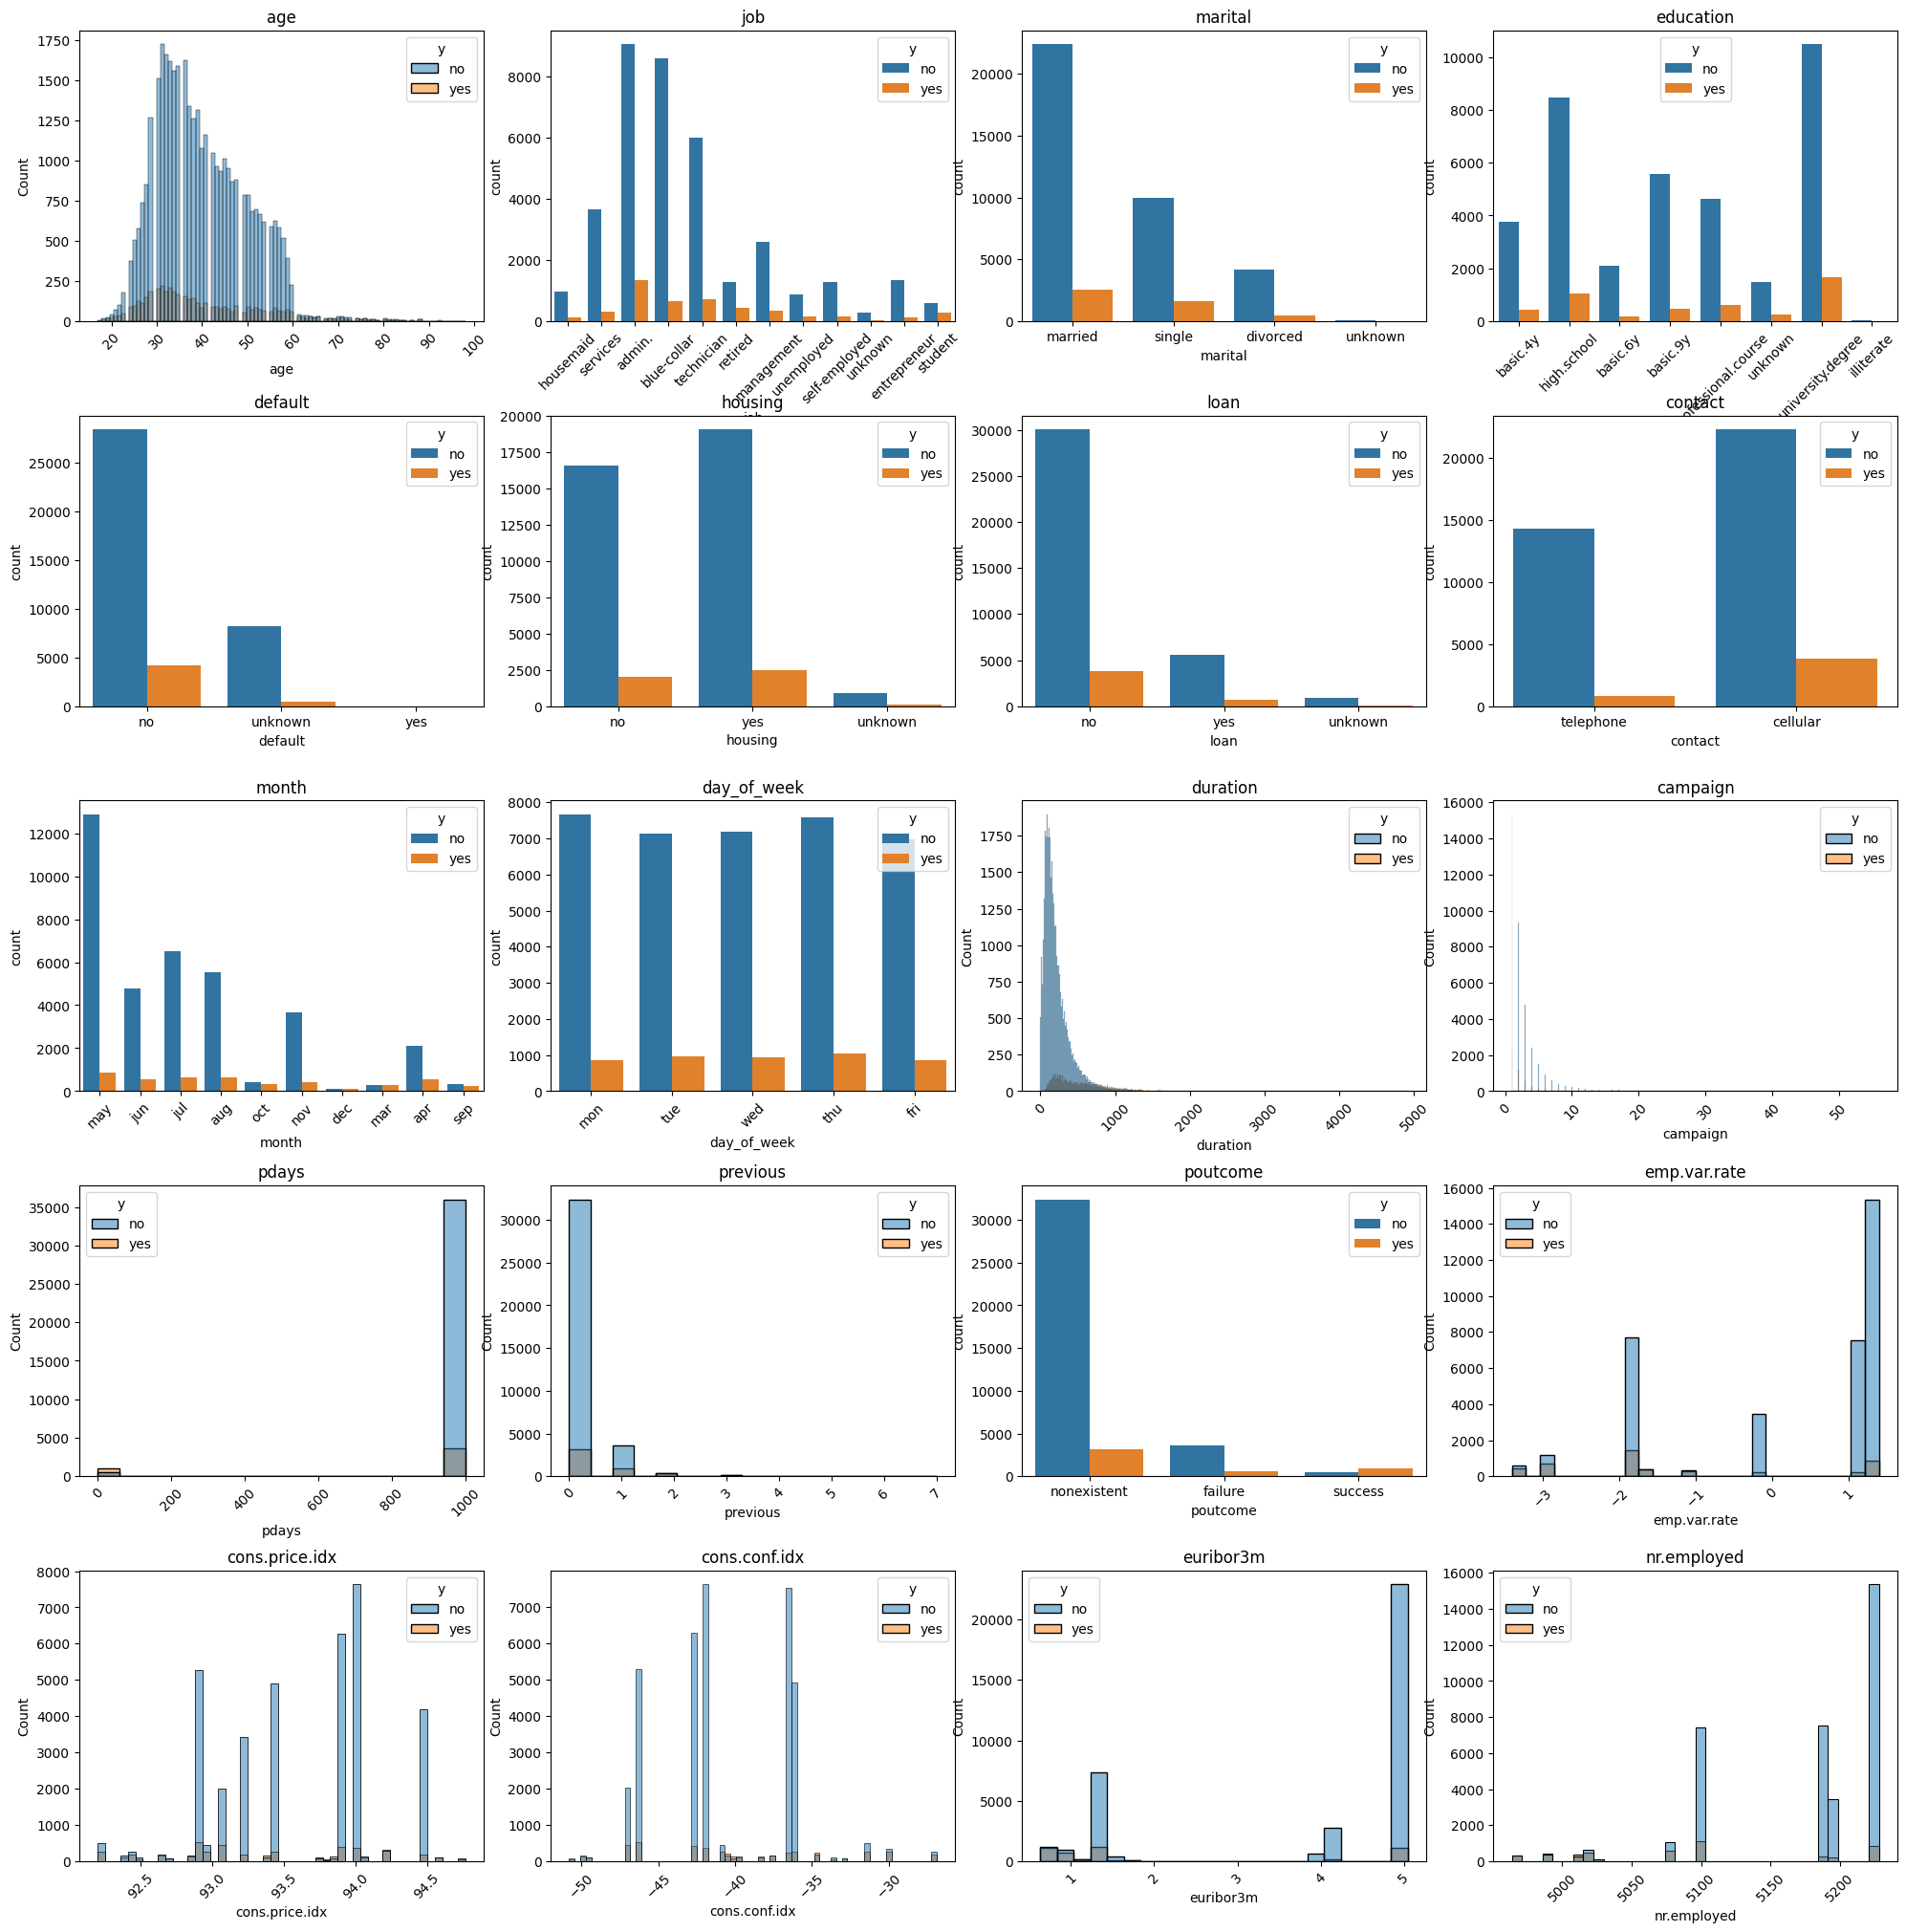

In [7]:
# Number of columns in df
n_cols = df.shape[1]

# Create a grid of subplots with size 12x12.  Grid should have 4 columns and the number of rows should be calculated based on the number of columns in the dataframe
plt.subplots(n_cols//4,4,figsize=(20,20))

# Add margins between each subplot
plt.tight_layout(pad=2.0, h_pad=5.0, w_pad=2.0)

col_idx = 0

# Loop through each column in the dataframe
for col in df.columns:

    if col == 'y':
        continue

    # if col is numeric
    if df[col].dtype in ['int64', 'float64']:
        # Plot in the ith position
        plt.subplot(n_cols//4,4,col_idx+1)
        sns.histplot(x=df[col], hue=df['y'])
    else:
        # Plot in the ith position
        plt.subplot(n_cols//4,4,col_idx+1)
        sns.countplot(x=col, hue='y', data=df)
    
    # if col has more than 4 unique values
    if len(df[col].unique()) > 4:
        # Rotate the xticks
        plt.xticks(rotation=45)
        
    # Add a title to the plot
    plt.title(col)
    col_idx += 1


In [8]:
# Dataframe with only the numeric columns
numeric_df = df.select_dtypes(include=[float, int])
numeric_df['y'] = df['y'].map({'no': 0, 'yes': 1})


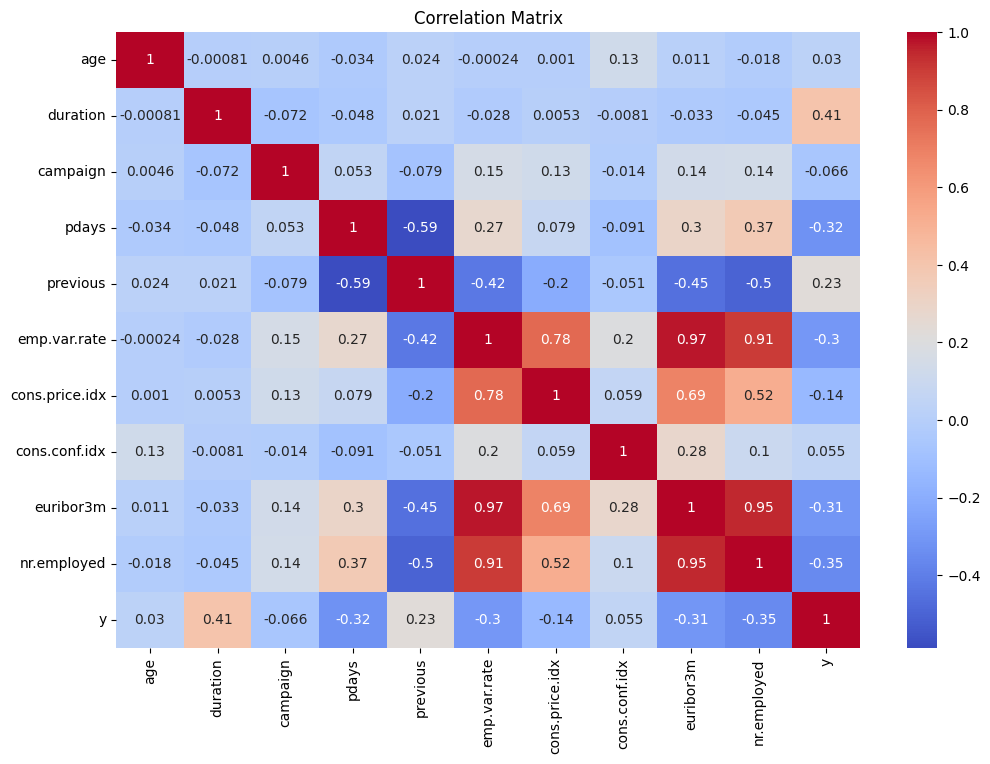

In [9]:
# Compute the correlation matrix for numeric features
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Feature Engineering

We must encode all non-numeric features before we can start building our models.

In [10]:
# List all non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# List all unique values in non-numeric columns and their counts
for col in non_numeric_cols:
    print(f'{col}: {df[col].unique()}')


job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital: ['married' 'single' 'divorced' 'unknown']
education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default: ['no' 'unknown' 'yes']
housing: ['no' 'yes' 'unknown']
loan: ['no' 'yes' 'unknown']
contact: ['telephone' 'cellular']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome: ['nonexistent' 'failure' 'success']
y: ['no' 'yes']


In [11]:
print(f'Number of unique values in "marital" column: {df["marital"].value_counts()}')

print('Percentage of each against target column:')
# Percentage of each value in 'marital' column where 'y' column is 'yes'
df.groupby('marital')['y'].value_counts(normalize=True)

Number of unique values in "marital" column: marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
Percentage of each against target column:


marital   y  
divorced  no     0.896769
          yes    0.103231
married   no     0.898439
          yes    0.101561
single    no     0.859910
          yes    0.140090
unknown   no     0.850000
          yes    0.150000
Name: proportion, dtype: float64

In [12]:
print(f'Number of unique values in "default" column: {df["default"].value_counts()}')

print('Percentage of each against target column:')
# Percentage of each value in 'default' column where 'y' column is 'yes'
df.groupby('default')['y'].value_counts(normalize=True)

Number of unique values in "default" column: default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
Percentage of each against target column:


default  y  
no       no     0.871197
         yes    0.128803
unknown  no     0.948464
         yes    0.051536
yes      no     1.000000
Name: proportion, dtype: float64

In [13]:
# One-hot encode columns 'job', 'marital', 'default', 'housing', 'loan', 'poutcome'
df = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan', 'poutcome'])


In [14]:
print(f'Number of unique values in "education" column: {df["education"].value_counts()}')

print('Percentage of each against target column:')
# Percentage of each value in 'education' column where 'y' column is 'yes'
df.groupby('education')['y'].value_counts(normalize=True)

Number of unique values in "education" column: education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
Percentage of each against target column:


education            y  
basic.4y             no     0.897510
                     yes    0.102490
basic.6y             no     0.917940
                     yes    0.082060
basic.9y             no     0.921754
                     yes    0.078246
high.school          no     0.891611
                     yes    0.108389
illiterate           no     0.777778
                     yes    0.222222
professional.course  no     0.886450
                     yes    0.113550
university.degree    no     0.862792
                     yes    0.137208
unknown              no     0.854913
                     yes    0.145087
Name: proportion, dtype: float64

In [15]:
# Combine 'illiterate' and 'unknown' values in education column
df['education'] = df['education'].replace('illiterate', 'unknown')

# Map values in education columns to integers
education_map = {'unknown': 0, 'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3, 'high.school': 4, 'professional.course': 5, 'university.degree': 6}
df['education'] = df['education'].map(education_map)

In [16]:
# Binary encode 'contact' column into 'contact_by_cell'
df['contact_by_cell'] = df['contact'].map({'cellular': 1, 'telephone': 0})

# Drop 'contact' column
df.drop(columns=['contact'], inplace=True)


#### Use cyclical encoding for `month` and `day_of_week`

In [17]:
# Cyclical encode 'month' column
df['month_sin'] = np.sin(2*np.pi*df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})/12)
df['month_cos'] = np.cos(2*np.pi*df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})/12)


In [18]:
# Cyclical encode 'day_of_week' column
df['day_of_week_sin'] = np.sin(2*np.pi*df['day_of_week'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})/5)
df['day_of_week_cos'] = np.cos(2*np.pi*df['day_of_week'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})/5)


In [19]:
# Drop 'month' and 'day_of_week' columns
df.drop(columns=['month', 'day_of_week'], inplace=True)

In [20]:
# Binary encode the target column
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [21]:
# Show resulting dataframe columns
df.columns

Index(['age', 'education', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'contact_by_cell', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

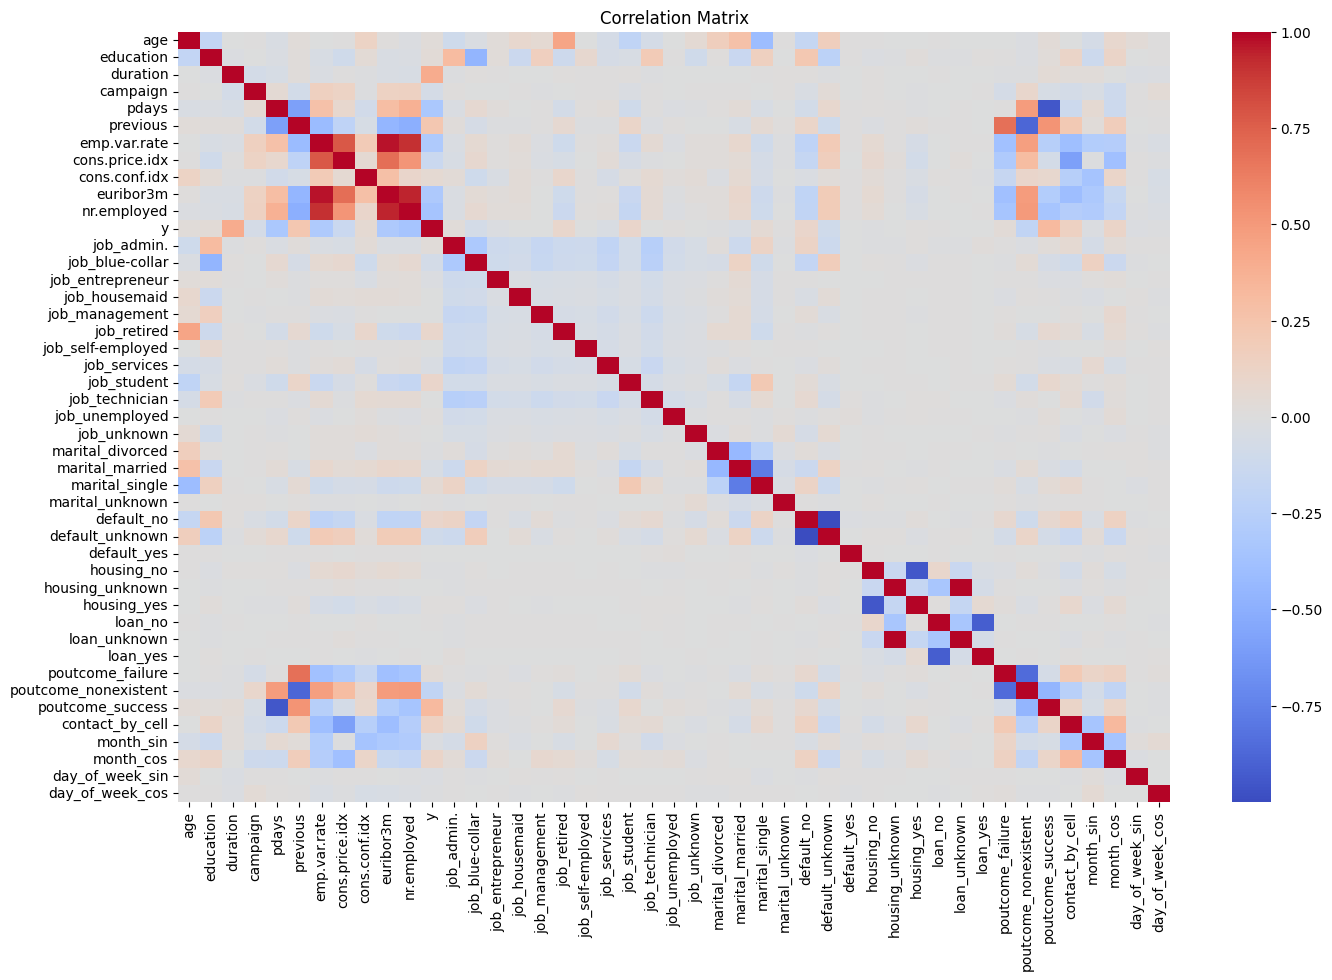

In [22]:
# Correlation matrix after encoding
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

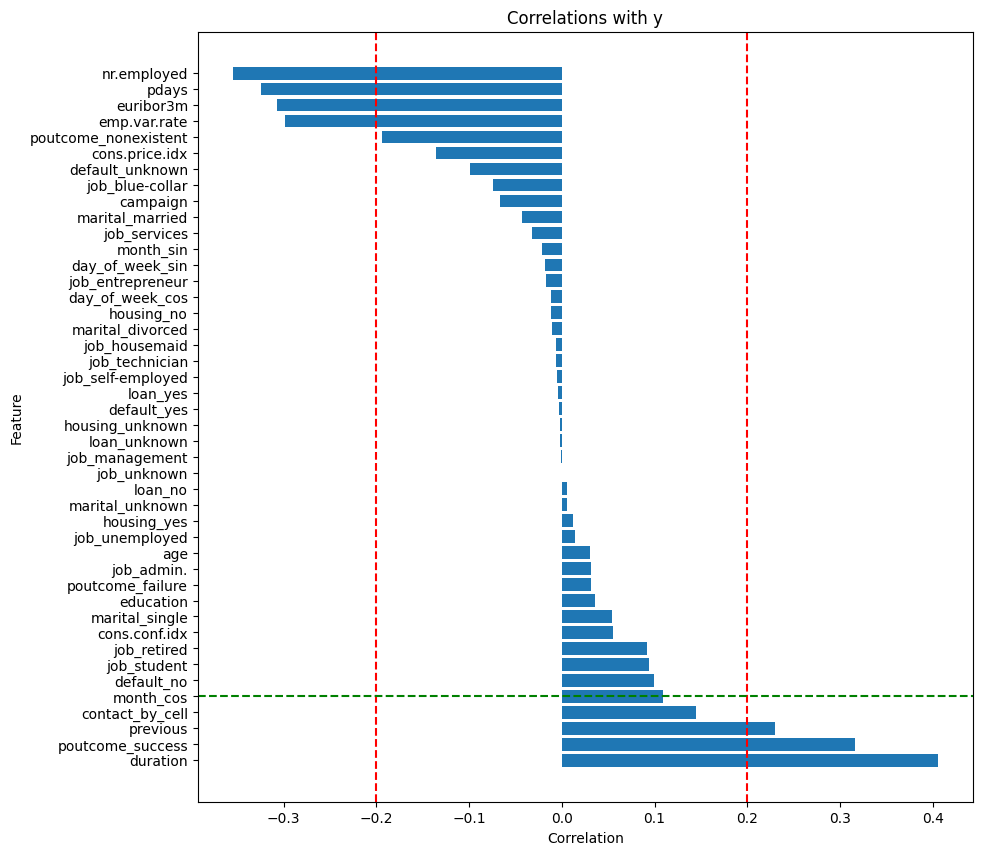

In [23]:
# List all correlations with the target column
correlations = correlation_matrix['y'].sort_values(ascending=False)

# Remove 'y' from the a series
correlations = correlations.drop('y')

# Plot all correlations with the target column
plt.figure(figsize=(10, 10))
plt.barh(correlations.index, correlations)

# add line at 0.2 and -0.2
plt.axvline(x=0.2, color='r', linestyle='--')
plt.axvline(x=-0.2, color='r', linestyle='--')

# add horizontal line
plt.axhline(y='month_cos', color='g', linestyle='--')

plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.title('Correlations with y')
plt.show()

### Train/Test Split


In [24]:
# Set the feature variables
X = df.drop(columns='y')

# Set the target variable
y = df['y']

In [25]:
# Split the data into 2/3 training and 1/3 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Index(['age', 'education', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'contact_by_cell', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

### Models Setup

In [ ]:
columns_to_scale = ['age', 'education', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed']

preprocessor = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    remainder="passthrough", 
    verbose_feature_names_out=False
)

#### Baseline Model

We will use a dummy classifier with the `most_frequent` strategy as the worst-case scenario given the significant class imbalance.


In [27]:
# Create a pipeline with a Logistic Regression model
pipe_dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy="most_frequent", random_state=42))
])

#### Logistic Regression Model

In [29]:
# Create a pipeline with a Logistic Regression model
pipe_logistic_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])


#### K-Nearest Neighbors

In [31]:
# Create a pipeline with a KNN model
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

#### Decision Trees

In [32]:
# Create a pipeline with a Decision Tree model
pipe_dtree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])


#### Support Vector Machines (SVM)

In [33]:
# Create a pipeline with a Decision Tree model
pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True, random_state=42))
])


### Model Comparisons


In [34]:
models = ['Baseline - DummyClassifer', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM']
pipe_dict = {
    'Baseline - DummyClassifer': pipe_dummy, 
    'Logistic Regression': pipe_logistic_reg, 
    'KNN': pipe_knn, 
    'Decision Tree': pipe_dtree, 
    'SVM': pipe_svm
}
train_times = {}
train_acc_dict = {}
test_acc_dict = {}
probabilities_dict = {}
roc_dict = {}
roc_auc_score_dict = {}

for model in models:
    print(model)
    start_time = dt.datetime.now()
    pipe_dict[model].fit(X_train, y_train)
    train_times[model] = dt.datetime.now() - start_time

    if model != 'Baseline - DummyClassifer':
        print(classification_report(y_test, pipe_dict[model].predict(X_test)))
    else:
        print(classification_report(y_test, pipe_dict[model].predict(X_test)), zero_division=0)

    train_acc_dict[model] = pipe_dict[model].score(X_train, y_train)
    test_acc_dict[model] = pipe_dict[model].score(X_test, y_test)

    probabilities_dict[model] = pipe_dict[model].predict_proba(X_test)[:, 1]
    roc_dict[model] = roc_curve(y_test, probabilities_dict[model])
    roc_auc_score_dict[model] = roc_auc_score(y_test, probabilities_dict[model])


Baseline - DummyClassifer
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12042
           1       0.00      0.00      0.00      1547

    accuracy                           0.89     13589
   macro avg       0.44      0.50      0.47     13589
weighted avg       0.79      0.89      0.83     13589

Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12042
           1       0.66      0.40      0.50      1547

    accuracy                           0.91     13589
   macro avg       0.80      0.69      0.73     13589
weighted avg       0.90      0.91      0.90     13589



/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

KNN
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12042
           1       0.58      0.39      0.46      1547

    accuracy                           0.90     13589
   macro avg       0.75      0.68      0.70     13589
weighted avg       0.89      0.90      0.89     13589

Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     12042
           1       0.49      0.50      0.50      1547

    accuracy                           0.88     13589
   macro avg       0.71      0.72      0.72     13589
weighted avg       0.89      0.88      0.88     13589

SVM
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12042
           1       0.66      0.39      0.49      1547

    accuracy                           0.91     13589
   macro avg       0.79      0.68      0.72     13589
weighted avg       0.90      0.91      0.90     1358

In [35]:
summary_df = pd.DataFrame({
    'Model': models,
    'Train Time (Seconds)': np.array(train_times.values()),
    'Train Accuracy': list(train_acc_dict.values()),
    'Test Accuracy': list(test_acc_dict.values()),
    'ROC-AUC Score': list(roc_auc_score_dict.values())
})
summary_df

,Model,Train Time (Seconds),Train Accuracy,Test Accuracy,ROC-AUC Score
0,Baseline - DummyClassifer,0:00:00.024011,0.887918,0.886158,0.500000
1,Logistic Regression,0:00:00.066020,0.911371,0.908823,0.923608
2,KNN,0:00:00.043973,0.927103,0.897859,0.854303
3,Decision Tree,0:00:00.148110,1.000000,0.883803,0.718386
4,SVM,0:00:27.280567,0.921449,0.908087,0.911136


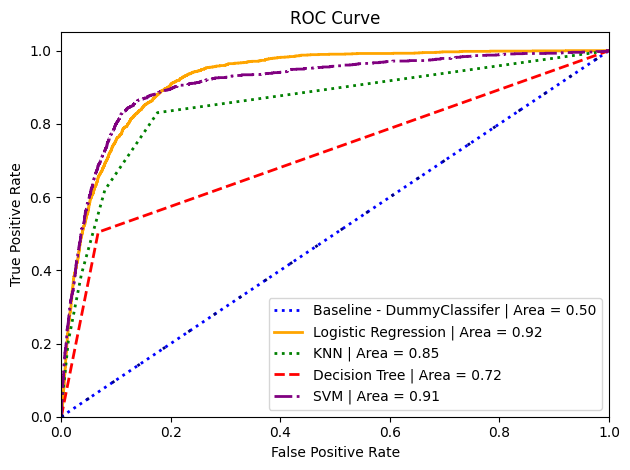

In [37]:
color_dict = {
    'Baseline - DummyClassifer': 'blue', 
    'Logistic Regression': 'orange', 
    'KNN': 'green', 
    'Decision Tree': 'red', 
    'SVM': 'purple'
}
linestyle_dict = {
    'Baseline - DummyClassifer': 'dotted',
    'Logistic Regression': 'solid', 
    'KNN': 'dotted', 
    'Decision Tree': 
    'dashed', 
    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in models:
    fpr, tpr, thresholds = roc_dict[model]
    roc_auc = roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Model Tuning

We will use GridSearch to find optimal hyperparameters for our models.  Since we are dealing with an imbalance target class, accuracy is not the best metric to use for scoring.  Recall measures how well a model identifies all actual positives.  It is the proportion of true positives among all actual positives.  For a marketing campaign, a high recall means capturing as many interested customers as possible, even if it includes contacting some who are not interested.

In [69]:
tuned_train_acc_dict = {}
tuned_test_acc_dict = {}
tuned_probabilities_dict = {}
tuned_roc_dict = {}
tuned_roc_auc_score_dict = {}

#### Logistic Regression

In [45]:
# search over different penalty options
lr_params = {
    'model__C': [0.1, 1, 10, 100],  # smaller values specify stronger regularization
    'model__penalty': ['l1', 'l2'], # l1 is Lasso, l2 is Ridge
    'model__solver': ['liblinear']  # lbfgs supports only 'l2'
}

lr_search = GridSearchCV(pipe_logistic_reg, lr_params, scoring='recall', error_score='raise')

lr_search.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear']},
             scoring='recall')

In [46]:
best_lr_model = lr_search.best_estimator_

lr_score = best_lr_model.score(X_test, y_test)

print(f'Best parameters: {lr_search.best_params_}')
print(f'Score for best Logistic Regression estimator: {lr_score: .2f}')

Best parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Score for best Logistic Regression estimator:  0.91


In [70]:
model = 'Logistic Regression'
print(classification_report(y_test, best_lr_model.predict(X_test)))

tuned_train_acc_dict[model] = best_lr_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_lr_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_lr_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12042
           1       0.66      0.40      0.50      1547

    accuracy                           0.91     13589
   macro avg       0.80      0.69      0.73     13589
weighted avg       0.90      0.91      0.90     13589



#### KNN

In [54]:
knn_params = {
    'model__n_neighbors': range(1, 20, 2),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_search = GridSearchCV(pipe_knn, knn_params, scoring='recall')
knn_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__n_neighbors': range(1, 20, 2),
                         'model__weights': ['uniform', 'distance']},
             scoring='recall')

In [55]:
best_knn_model = knn_search.best_estimator_

knn_score = best_knn_model.score(X_test, y_test)

print(f'Best parameters: {knn_search.best_params_}')
print(f'Score for best KNN estimator: {knn_score: .2f}')

Best parameters: {'model__algorithm': 'auto', 'model__n_neighbors': 1, 'model__weights': 'uniform'}
Score for best KNN estimator:  0.88


In [71]:
model = 'KNN'
print(classification_report(y_test, best_knn_model.predict(X_test)))

tuned_train_acc_dict[model] = best_knn_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_knn_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_knn_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12042
           1       0.49      0.44      0.46      1547

    accuracy                           0.88     13589
   macro avg       0.71      0.69      0.70     13589
weighted avg       0.88      0.88      0.88     13589



In [61]:
knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
knn_cv_df

,model__algorithm,model__n_neighbors,model__weights,score
0,auto,1,uniform,0.432729
1,auto,1,distance,0.432729
2,auto,3,uniform,0.421081
3,auto,3,distance,0.424962
4,auto,5,uniform,0.403297
...,...,...,...,...
75,brute,15,distance,0.381626
76,brute,17,uniform,0.363517
77,brute,17,distance,0.371603
78,brute,19,uniform,0.363195


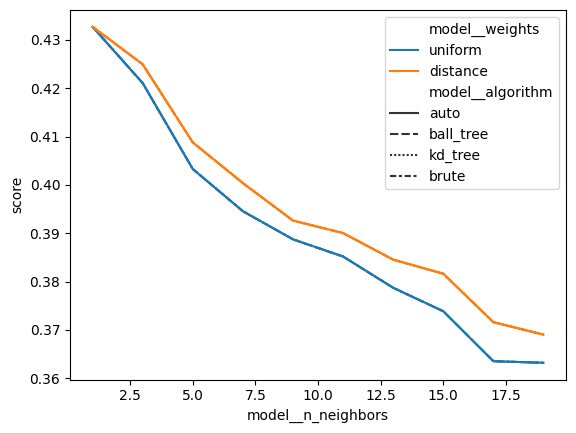

In [59]:
#plot knn scores
knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
sns.lineplot(data=knn_cv_df, x='model__n_neighbors', y='score', hue='model__weights', style='model__metric')
plt.show()

#### Decision Tree

In [64]:
dt_params = {
    'model__max_depth': range(1, 15),
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': ['auto', 'sqrt', 'log2'], # 'log_loss' criterion supports only 'auto
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

dt_search = GridSearchCV(pipe_dtree, dt_params, scoring='recall')
dt_search.fit(X_train, y_train)

/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1890 fits failed out of a total of 5670.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1890 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dm

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 15),
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='recall')

In [65]:
best_dt_model = dt_search.best_estimator_

dt_score = best_dt_model.score(X_test, y_test)

print(f'Best parameters: {dt_search.best_params_}')
print(f'Score for best Decision Tree estimator: {dt_score: .2f}')

Best parameters: {'model__criterion': 'gini', 'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Score for best Decision Tree estimator:  0.90


In [72]:
model = 'Decision Tree'
print(classification_report(y_test, best_dt_model.predict(X_test)))

tuned_train_acc_dict[model] = best_dt_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_dt_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_dt_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     12042
           1       0.57      0.46      0.51      1547

    accuracy                           0.90     13589
   macro avg       0.75      0.71      0.73     13589
weighted avg       0.89      0.90      0.89     13589



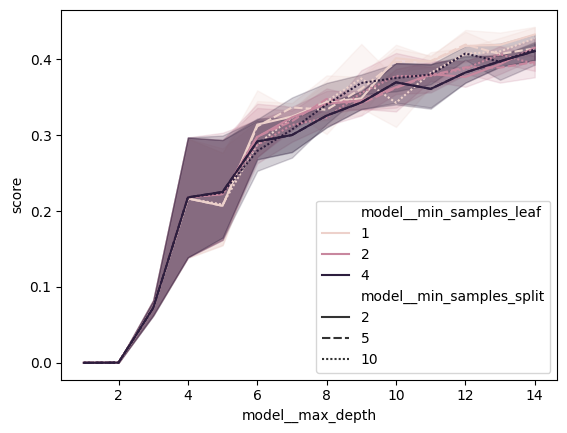

In [66]:
#plot decision tree scores
tree_cv_df = pd.DataFrame(dt_search.cv_results_['params'])
tree_cv_df['score'] = dt_search.cv_results_['mean_test_score']
sns.lineplot(data=tree_cv_df, x='model__max_depth', y='score', hue='model__min_samples_leaf', style='model__min_samples_split')
plt.show()

#### SVM

In [67]:
svc_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['rbf'],
    'model__gamma': [1, 0.1, 0.01, 0.001],
}

svc_search = GridSearchCV(pipe_svm, svc_params, scoring='recall')
svc_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'model__kernel': ['rbf']},
             scoring='recall')

In [74]:
best_svc_model = svc_search.best_estimator_

svc_score = best_svc_model.score(X_test, y_test)

print(f'Best parameters: {svc_search.best_params_}')
print(f'Score for best Decision Tree estimator: {svc_score: .2f}')

Best parameters: {'model__C': 100, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Score for best Decision Tree estimator:  0.89


In [75]:
model = 'SVM'
print(classification_report(y_test, best_svc_model.predict(X_test)))

tuned_train_acc_dict[model] = best_svc_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_svc_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_svc_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     12042
           1       0.51      0.48      0.50      1547

    accuracy                           0.89     13589
   macro avg       0.72      0.71      0.72     13589
weighted avg       0.89      0.89      0.89     13589



### Comparisons after hyperparameter tuning

In [78]:
tuned_models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']
summary_df = pd.DataFrame({
    'Model': tuned_models,
    'Train Accuracy': list(tuned_train_acc_dict.values()),
    'Test Accuracy': list(tuned_test_acc_dict.values()),
    'ROC-AUC Score': list(tuned_roc_auc_score_dict.values())
})
summary_df

,Model,Train Accuracy,Test Accuracy,ROC-AUC Score
0,Logistic Regression,0.911371,0.908823,0.923460
1,KNN,1.000000,0.883141,0.689562
2,Decision Tree,0.932468,0.898962,0.835507
3,SVM,0.993076,0.888660,0.896701


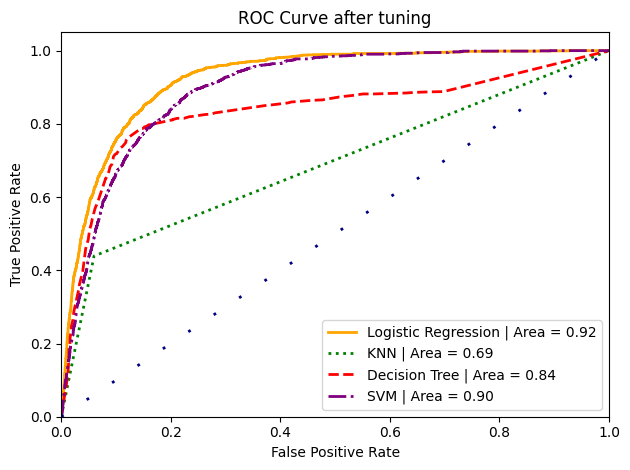

In [77]:
color_dict = {
    'Logistic Regression': 'orange', 
    'KNN': 'green', 
    'Decision Tree': 'red', 
    'SVM': 'purple'
}
linestyle_dict = {
    'Logistic Regression': 'solid', 
    'KNN': 'dotted', 
    'Decision Tree': 
    'dashed', 
    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in tuned_models:
    fpr, tpr, thresholds = tuned_roc_dict[model]
    roc_auc = tuned_roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after tuning')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance

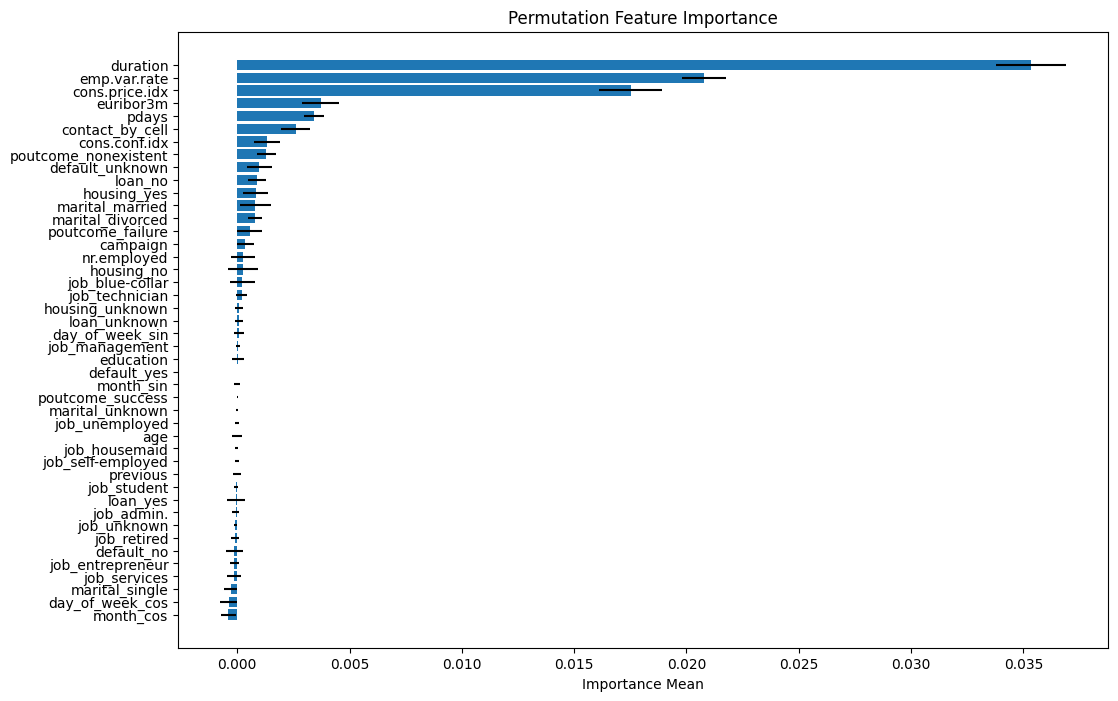

In [79]:
# Calculate permutation importance for Logistic Regression model
lr_perm_importance = permutation_importance(best_lr_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the feature names
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': lr_perm_importance.importances_mean,
    'Importance Std': lr_perm_importance.importances_std
})

# Sort the DataFrame by importance mean
importances_df = importances_df.sort_values(by='Importance Mean', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance Mean'], xerr=importances_df['Importance Std'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.title('Permutation Feature Importance')
plt.xlabel('Importance Mean')
plt.show()

In [83]:
# Calculate permutation importance for SVM model
svm_perm_importance = permutation_importance(best_svc_model, X_test, y_test, n_repeats=1, random_state=42)

# Get the feature names
feature_names = X.columns

# Create a DataFrame for better visualization
# importances_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance Mean': lr_perm_importance.importances_mean,
#     'Importance Std': lr_perm_importance.importances_std
# })

# Sort the DataFrame by importance mean
# importances_df = importances_df.sort_values(by='Importance Mean', ascending=False)

sorted_idx = svm_perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], feature_names.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Plot the feature importances
# plt.figure(figsize=(12, 8))
# plt.barh(importances_df['Feature'], importances_df['Importance Mean'], xerr=importances_df['Importance Std'])
# plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# plt.title('Permutation Feature Importance')
# plt.xlabel('Importance Mean')
# plt.show()

KeyboardInterrupt: 

In [88]:
coefs = best_lr_model.named_steps.model.coef_
coefs[0]

array([ 0.02317661,  0.06507566,  1.22110962, -0.0998786 , -0.17673387,
       -0.02740689, -1.18246971,  0.77229001,  0.28162038, -0.38361929,
        0.11460249, -0.03938723, -0.38762996, -0.36126355, -0.12136571,
       -0.02626614,  0.2764735 , -0.08004264, -0.37092108,  0.10546451,
       -0.16049047, -0.10541635, -0.14827414, -0.35080141, -0.4296535 ,
       -0.22816086, -0.41050348, -0.20789481, -0.54799149, -0.66323295,
       -0.44305506, -0.53376802, -0.44229617, -0.40303911, -0.53376802,
       -0.48231212, -0.9995508 , -0.4032138 , -0.01635465,  0.84329849,
        0.01625699,  0.14831985, -0.05802269, -0.08218404])

In [101]:
# Create DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs[0],
    'Abs_Coefs': np.abs(coefs[0])
})
coefs_df.sort_values(['Coefficient'], ascending = False).set_index('Feature')

,Coefficient,Abs_Coefs
Feature,,
duration,1.221110,1.221110
contact_by_cell,0.843298,0.843298
cons.price.idx,0.772290,0.772290
cons.conf.idx,0.281620,0.281620
job_retired,0.276474,0.276474
month_cos,0.148320,0.148320
nr.employed,0.114602,0.114602
job_student,0.105465,0.105465
education,0.065076,0.065076


##### Questions